In [ ]:
%pip install llama-index
%pip install langchain

## 先搜索，后提示

In [16]:
import openai, os
from llama_index import GPTSimpleVectorIndex, SimpleDirectoryReader, ServiceContext

openai.api_key = os.environ.get("OPENAI_API_KEY")

documents = SimpleDirectoryReader('./data/mr_fujino').load_data()
index = GPTSimpleVectorIndex.from_documents(documents)

index.save_to_disk('index_mr_fujino.json')

INFO:llama_index.token_counter.token_counter:> [build_index_from_nodes] Total LLM token usage: 0 tokens
INFO:llama_index.token_counter.token_counter:> [build_index_from_nodes] Total embedding token usage: 6763 tokens


In [17]:
index = GPTSimpleVectorIndex.load_from_disk('index_mr_fujino.json')
response = index.query("鲁迅先生在日本学习医学的老师是谁？")
print(response)

INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 2984 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 34 tokens



鲁迅先生在日本学习医学的老师是藤野严九郎先生。


In [18]:
response = index.query("鲁迅先生是去哪里学的医学？", verbose=True)
print(response)

> Got node text: 藤野先生

东京也无非是这样。上野的樱花烂熳的时节，望去确也像绯红的轻云，但花下也缺不了成群结队的“清国留学生”的速成班，头顶上盘着大辫子，顶得学生制帽的顶上高高耸起，形成一座富士山。也有解散辫子，盘得平的，除下帽来，油光可鉴，宛如小姑娘的发髻一般，还要将脖子扭几扭。实在标致极了。

中国留学生会馆的门房里有几本书买，有时还值得去一转；倘在上午，里面的几间洋房里倒也还可以坐坐的。但到傍晚，有...


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 2969 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 26 tokens



鲁迅先生去仙台的医学专门学校学习医学。


In [20]:
from llama_index import QuestionAnswerPrompt
query_str = "鲁迅先生去哪里学的医学？"
DEFAULT_TEXT_QA_PROMPT_TMPL = (
    "Context information is below. \n"
    "---------------------\n"
    "{context_str}"
    "\n---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the question: {query_str}\n"
)
QA_PROMPT = QuestionAnswerPrompt(DEFAULT_TEXT_QA_PROMPT_TMPL)

response = index.query(query_str, text_qa_template=QA_PROMPT, verbose=True)
print(response)

> Got node text: 藤野先生

东京也无非是这样。上野的樱花烂熳的时节，望去确也像绯红的轻云，但花下也缺不了成群结队的“清国留学生”的速成班，头顶上盘着大辫子，顶得学生制帽的顶上高高耸起，形成一座富士山。也有解散辫子，盘得平的，除下帽来，油光可鉴，宛如小姑娘的发髻一般，还要将脖子扭几扭。实在标致极了。

中国留学生会馆的门房里有几本书买，有时还值得去一转；倘在上午，里面的几间洋房里倒也还可以坐坐的。但到傍晚，有...


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 2968 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 25 tokens



鲁迅先生去仙台的医学专门学校学习医学。


In [28]:
QA_PROMPT_TMPL = (
    "下面的“我”指的是鲁迅先生 \n"
    "---------------------\n"
    "{context_str}"
    "\n---------------------\n"
    "根据这些信息，请回答问题: {query_str}\n"
    "如果您不知道的话，请回答不知道\n"
)
QA_PROMPT = QuestionAnswerPrompt(QA_PROMPT_TMPL)

response = index.query("请问林黛玉和贾宝玉是什么关系？", text_qa_template=QA_PROMPT)

print(response)

INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 3020 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 37 tokens



不知道


## 通过llama_index对于文章进行小结

In [ ]:
%pip install spacy
%python -m spacy download zh_core_web_sm

In [8]:
from langchain.chat_models import ChatOpenAI
from langchain.text_splitter import SpacyTextSplitter
from llama_index import GPTListIndex, LLMPredictor, ServiceContext
from llama_index.node_parser import SimpleNodeParser

# define LLM
llm_predictor = LLMPredictor(llm=ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo", max_tokens=1024))

text_splitter = SpacyTextSplitter(pipeline="zh_core_web_sm", chunk_size = 2048)
parser = SimpleNodeParser(text_splitter=text_splitter)
documents = SimpleDirectoryReader('./data/mr_fujino').load_data()
nodes = parser.get_nodes_from_documents(documents)

service_context = ServiceContext.from_defaults(llm_predictor=llm_predictor)

list_index = GPTListIndex(nodes=nodes, service_context=service_context)
response = list_index.query("下面鲁迅先生以第一人称‘我’写的内容，请你用中文总结一下:", response_mode="tree_summarize")
print(response)

INFO:llama_index.token_counter.token_counter:> [build_index_from_nodes] Total LLM token usage: 0 tokens
INFO:llama_index.token_counter.token_counter:> [build_index_from_nodes] Total embedding token usage: 0 tokens
INFO:llama_index.indices.common_tree.base:> Building index from nodes: 2 chunks
INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 9787 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 0 tokens


鲁迅先生回忆了自己在日本学医期间的经历，描述了自己在解剖实习中的经历，以及与教授藤野先生的交往。他还提到了一些不愉快的事情，比如遭到同学的诽谤和歧视，以及看到中国人被枪毙时的感受。最后，他告诉藤野先生自己将不再学医，而是想学生物学。他想起了一个人，这个人是他的老师，他对鲁迅很热心，给他很多鼓励和教诲。鲁迅现在只有他的照片，但是每次看到他的照片，都会让他感到勇气和良心发现。


In [9]:
from llama_index import GPTTreeIndex

# define LLM
tree_index = GPTTreeIndex(nodes=nodes, service_context=service_context)
response = tree_index.query("下面鲁迅先生以第一人称‘我’写的内容，请你用中文总结一下:", mode="summarize")
print(response)

INFO:llama_index.token_counter.token_counter:> [build_index_from_nodes] Total LLM token usage: 0 tokens
INFO:llama_index.token_counter.token_counter:> [build_index_from_nodes] Total embedding token usage: 0 tokens
INFO:llama_index.indices.query.tree.summarize_query:> Starting query: 下面鲁迅先生以第一人称‘我’写的内容，请你用中文总结一下:
INFO:llama_index.indices.common_tree.base:> Building index from nodes: 2 chunks
INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 9653 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 0 tokens


鲁迅先生回忆了自己在日本学医的经历，描述了自己在解剖实习中遇到的困难和藤野先生的态度，以及自己在学校中遭受的歧视和流言。最后，他告诉藤野先生自己不再学医，离开仙台，并且与藤野先生告别。他想写信给一个老师，但不知道该写些什么。这个老师的名字不为人所知，但他的性格很伟大。鲁迅现在只有他的照片，但每次看到照片都会让他感到勇气和良心发现。


## 支持图片的多模态

In [1]:
from llama_index import SimpleDirectoryReader, GPTSimpleVectorIndex
from llama_index.readers.file.base import DEFAULT_FILE_EXTRACTOR, ImageParser
from llama_index.response.notebook_utils import display_response, display_image
from llama_index.indices.query.query_transform.base import ImageOutputQueryTransform

image_parser = ImageParser(keep_image=True, parse_text=True)
file_extractor = DEFAULT_FILE_EXTRACTOR
file_extractor.update(
{
    ".jpg": image_parser,
    ".png": image_parser,
    ".jpeg": image_parser,
})

# NOTE: we add filename as metadata for all documents
filename_fn = lambda filename: {'file_name': filename}

receipt_reader = SimpleDirectoryReader(
    input_dir='./data/receipts', 
    file_extractor=file_extractor, 
    file_metadata=filename_fn,
)
receipt_documents = receipt_reader.load_data()

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [3]:
receipts_index = GPTSimpleVectorIndex.from_documents(receipt_documents)

INFO:llama_index.token_counter.token_counter:> [build_index_from_nodes] Total LLM token usage: 0 tokens
INFO:llama_index.token_counter.token_counter:> [build_index_from_nodes] Total embedding token usage: 2182 tokens


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 1004 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 30 tokens


**`Final Response:`** The last time you went to McDonald's was on 03/10/2018 at 07:39:12 PM and you spent $26.15. Here is the receipt from your visit: <img src="data/receipts/1100-receipt.jpg" width="400" />

---

**`Source Node 1/1`**

**Document ID:** 6981dd10-e61c-4cda-b2a9-6275b07152fb<br>**Similarity:** 0.7982134977000751<br>**Text:** file_name: data/receipts/1100-receipt.jpg

<s_menu><s_nm> Story</s_nm><s_num> 16725 Stony Platin ...<br>**Image:**

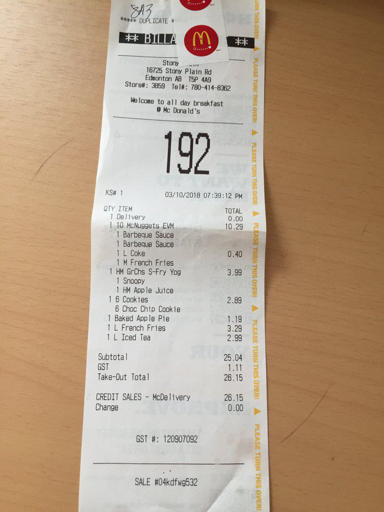

In [4]:
receipts_response = receipts_index.query(
    'When was the last time I went to McDonald\'s and how much did I spend. \
    Also show me the receipt from my visit.',
    query_transform=ImageOutputQueryTransform(width=400)
)

display_response(receipts_response)